# **7. Validacion Avanzada, Tuning e Interpretabilidad a los modelos estudiados**

## 7. Clasificador Bayesiano

In [2]:

from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC


from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve, auc, classification_report, roc_auc_score
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN
import joblib




Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [3]:
df = pd.read_csv("C:\\Users\\taran\\OneDrive\\Desktop\\ML_PF_entrega3\\PF_GestHospitalClasificacion_Entrega3\\data\\diabetic_data_limpio.csv")

In [4]:
X = df.drop("readmitted", axis=1)
y = df["readmitted"].map({"No": 0, "Yes": 1}) 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [6]:
cat_features = X.select_dtypes(include=["object", "category"]).columns
num_features = X.select_dtypes(include=["int64", "float64"]).columns

In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_features)
    ]
)

In [8]:
ridge_saga_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),  # tu ColumnTransformer
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(
        penalty="l2",
        solver="saga",
        max_iter=1000,
        random_state=42,
        n_jobs=4
    ))
])

In [9]:
def evaluar_modelo(modelo, X_test, y_test, nombre_modelo="Modelo"):
    # Predicciones
    y_pred = modelo.predict(X_test)
    y_pred_proba = modelo.predict_proba(X_test)[:, 1] if hasattr(modelo, "predict_proba") else None

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores reales")
    plt.title(f"Matriz de Confusión - {nombre_modelo}")
    plt.show()

    # Métricas básicas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calcular AUC si hay probabilidades
    auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None

    # Mostrar métricas
    print(f"Modelo: {nombre_modelo}")
    print("Accuracy:", round(accuracy, 3))
    print("Precision:", round(precision, 3))
    print("Recall:", round(recall, 3))
    print("F1-score:", round(f1, 3))
    if auc is not None:
        print("AUC:", round(auc, 3))
    print("\nReporte de clasificación:\n", classification_report(y_test, y_pred))

    # Curva ROC
    if y_pred_proba is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"Curva ROC - {nombre_modelo}")
        plt.legend(loc="lower right")
        plt.show()

    # Retornar resultados en formato de diccionario
    return {
        "Modelo": nombre_modelo,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "AUC": auc
    }


In [10]:
param_grid = {
    "classifier__C": np.logspace(-3, 3, 7)  # valores desde 0.001 a 1000
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=ridge_saga_pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=4,
    verbose=1
)


In [11]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\taran\miniconda3\envs\base_finalML_venv\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses'],
      dtype='object')),
                                                                        ('...
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change'],
      dtype='object'))])),
                                       ('smote', SMOTE(random_state=42)),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000,
                                                           n_jobs=4,
                                                           random_state=42,
                                                           solver='saga'))]),
             n_jobs=4,
             param_grid={'classifier__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='roc_auc', verbose=1)

In [12]:
best_ridge_saga = grid_search.best_estimator_

print("Mejores hiperparámetros:", grid_search.best_params_)
print("Mejor AUC (CV):", grid_search.best_score_)

# Predicciones en test
y_pred = best_ridge_saga.predict(X_test)
y_pred_proba = best_ridge_saga.predict_proba(X_test)[:, 1]

# Métricas
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_pred_proba))

Mejores hiperparámetros: {'classifier__C': np.float64(1000.0)}
Mejor AUC (CV): 0.6795034428648699
Accuracy: 0.6262651075955586
Precision: 0.5961413396921743
Recall: 0.5862914401449739
F1: 0.591175364110281
AUC: 0.6800578326429304


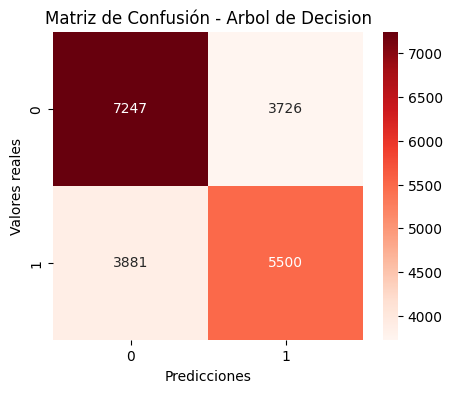

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Reds")
plt.xlabel("Predicciones")
plt.ylabel("Valores reales")
plt.title("Matriz de Confusión - Arbol de Decision")
plt.show()

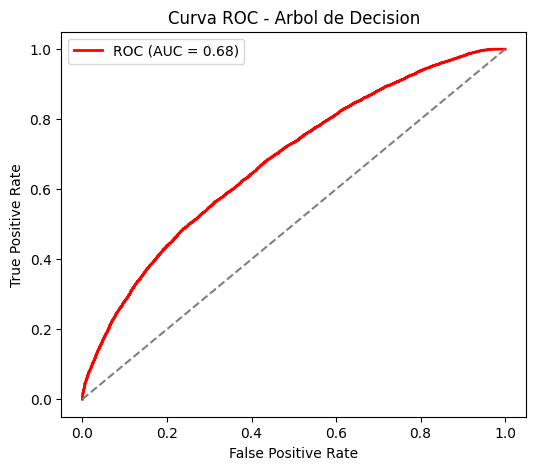

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc_val = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC (AUC = {auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Arbol de Decision")
plt.legend()
plt.show()

In [16]:
joblib.dump(best_ridge_saga, "best_ridge_saga_model.pkl")
print("Modelo LogRes  guardado en best_ridge_saga_model.pkl")


Modelo LogRes  guardado en best_ridge_saga_model.pkl
